# *eht-imaging* M87 tutorial

---

`eht-imaging` is a Python software for radio interferometric simulation, calibration, analysis, and imaging. Code and documentation can be found on [GitHub](https://github.com/achael/eht-imaging)

This notebook is an eht-imaging tutorial with an example script to produce polarized images of M87* from EHT data. This is a simplified script and should **not** be taken to be identical to the published results from eht-imaging

Please refer to and cite [EHT Paper IV](https://iopscience.iop.org/article/10.3847/2041-8213/ab0e85) and [EHT Paper VII](https://iopscience.iop.org/article/10.3847/2041-8213/abe71d) for details of the actual imaging procedure used for the EHT M87 results. 

If you wish to use EHT 2017 data for more than this tutorial, please consult the [EHT data archive](https://eventhorizontelescope.org/for-astronomers/data) 

## Prerequisites
Running this notebook requires that `eht-imaging` and its dependencies are installed (see README on [GitHub](https://github.com/achael/eht-imaging)). If you do not have `nfft` installed, you can set `ttype=direct` or `ttype=fast` in the following.

In [1]:
import glob
import ehtim as eh
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.rcParams['text.usetex'] = False

import os

ttype='direct'

ci_avg = True

Welcome to eht-imaging! v 1.2.10 



/Users/jasperchong/PycharmProjects/Github/eht-imaging/ehtim/__init__.py:58: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Load Data and Array

In [2]:
# create directory for results
outpath = './tutorial_results/ehtim_tutorial_m87'
if not os.path.exists(os.path.dirname(outpath)):
    os.makedirs(os.path.dirname(outpath))

In [3]:
arr = eh.array.load_txt('./arrays/EHT2017_template.txt') # array
obs_in = eh.obsdata.load_uvfits('./data/hops_lo_3601_M87+zbl-dtcal_selfcal.uvfits')

/Users/jasperchong/PycharmProjects/Github/eht-imaging/ehtim/io/load.py:840: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  tdata = np.loadtxt(filename, dtype=bytes, comments='#').astype(str)


Loading uvfits:  ./data/hops_lo_3601_M87+zbl-dtcal_selfcal.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4


## Imaging Parameters

In [4]:
#############
#Parameters
#############
# systematic noise fraction
sys_noise = 0.005 

# prior info
zbl = 0.6 # zero baseline flux
fov = 120.*eh.RADPERUAS # image fov
npix = 64 # image size
prior_fwhm = 60*eh.RADPERUAS #prior fwhm

# imaging params
maxit_i = 200
selfcal_iter = 3
#! Removed vis, worth trying it again after adding vis 
data_term_i = {'cphase':10, 'logcamp':10} # {'vis':10, 'cphase':10, 'logcamp':10}
reg_term_i = {'simple':100, 'tv2':1.}
blurfrac = 1
epsilon_tv = 1.e-10

# polarimetric imaging params
data_term_p={'m':1.,'pvis':1.}
reg_term_p={'hw':100.,'ptv':1.}
maxit_p=200
polcal_iter=25 # this was 50 in the original script, but 25 looks ok
sub_polcal_iter=3
polcal_sites=['AZ','LM','PV','SP']
leakage_tol=1

## Prepare data


In [5]:
# flag JCMT and SR if present
obs_in = obs_in.flag_sites(['JC','SR'])

# replace tarr
obs_in.tarr = arr.tarr

# add scans and scan average
obs_in.add_scans()
if not ci_avg:
    obs_in = obs_in.avg_coherent(0., scan_avg=True) 
    print('averaging obs_in')

# Add a small amount of non-closing noise to everything 
obs_in = obs_in.add_fractional_noise(sys_noise)

# Drop stokes I nans
mask_nan = np.isnan(obs_in.data['vis']) \
                     + np.isnan(obs_in.data['qvis']) \
                     + np.isnan(obs_in.data['uvis']) \
                     + np.isnan(obs_in.data['vvis'])
obs_in.data = obs_in.data[~mask_nan]

# nominal resolution
res = obs_in.res()

Flagged 0/5877 visibilities


In [6]:
# flag low snr data to prevnet divide by 0 issues 
# obs_in = obs_in.flag_low_snr(snr_cut=2)
#todo try to cut off invalid rows after

In [7]:
# if ci_avg:
obs_in.add_cphase(scan_avg=ci_avg)
obs_in.add_logcamp(scan_avg=ci_avg)

#? Not sure why this show a divide by 0 error, but it doesn't seem to prevent reconstruction

print(obs_in.cphase.shape, obs_in.logcamp.shape) 

/Users/jasperchong/PycharmProjects/Github/eht-imaging/ehtim/statistics/dataframes.py:749: FutureWarning: The provided callable <function min at 0x10493ca40> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  cdf2 = cdf2.groupby(grouping).agg(aggregated).reset_index()
/Users/jasperchong/PycharmProjects/Github/eht-imaging/ehtim/statistics/dataframes.py:749: FutureWarning: The provided callable <function mean at 0x10493d300> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  cdf2 = cdf2.groupby(grouping).agg(aggregated).reset_index()


updated self.cphase: avg_time 0.000000 s, scan_avg True

updated self.lcamp: no averaging
updated self.logcamp: avg_time 0.000000 s, scan_avg True

(161,) (252,)


/Users/jasperchong/PycharmProjects/Github/eht-imaging/ehtim/statistics/dataframes.py:837: FutureWarning: The provided callable <function min at 0x10493ca40> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  cdf2 = cdf2.groupby(grouping).agg(aggregated).reset_index()
/Users/jasperchong/PycharmProjects/Github/eht-imaging/ehtim/statistics/dataframes.py:837: FutureWarning: The provided callable <function mean at 0x10493d300> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  cdf2 = cdf2.groupby(grouping).agg(aggregated).reset_index()


### Try to drop invalid rows in cphase and logcamp

In [8]:
data = obs_in.logcamp

# Assuming your array is named 'data'
has_nan = False
has_inf = False

# Loop through each field name in the structured array
for name in data.dtype.names:
    # Check if the field is a floating-point type
    if np.issubdtype(data.dtype[name], np.floating):
        # Check for NaNs
        if np.isnan(data[name]).any():
            print(f"Column '{name}' has NaN values.")
            has_nan = True
            
        # Check for Infs
        if np.isinf(data[name]).any():
            print(f"Column '{name}' has Inf values.")
            has_inf = True

if not has_nan and not has_inf:
    print("No NaN or Inf values found.")

No NaN or Inf values found.


In [9]:

for data in (obs_in.logcamp, obs_in.cphase):
    # 1. Create a mask initialized to True (keep all rows initially)
    keep_mask = np.ones(len(data), dtype=bool)

    # 2. Iterate through columns to find bad values
    for name in data.dtype.names:
        # Only check floating-point columns
        if np.issubdtype(data.dtype[name], np.floating):
            # Find NaNs or Infs in this specific column
            bad_values = np.isnan(data[name]) | np.isinf(data[name])
            
            # Update the master mask: If a row is bad in this column, mark it False
            keep_mask &= ~bad_values

    # 3. Apply the mask to create a new array
    clean_data = data[keep_mask]

    # Optional: Check what happened
    print(f"Original rows: {len(data)}")
    print(f"Cleaned rows:  {len(clean_data)}")
    print(f"Dropped:       {len(data) - len(clean_data)}")

Original rows: 252
Cleaned rows:  252
Dropped:       0
Original rows: 161
Cleaned rows:  161
Dropped:       0


## Stokes I imaging

In [ ]:
# make a prior
gaussprior = eh.image.make_square(obs_in, npix, fov)
gaussprior = gaussprior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))

# set up imager
imgr = eh.imager.Imager(obs_in, gaussprior, gaussprior,
                        flux=zbl, maxit=maxit_i, 
                        data_term=data_term_i, reg_term=reg_term_i,
                        norm_reg=True,epsilon_tv=epsilon_tv, ttype=ttype,
                        # maxset=True #! experiment to see if this stops reduction
                        )
# iterate imaging steps
for repeat in range(selfcal_iter):
    imgr.make_image_I(show_updates=False)
    init = imgr.out_last().blur_circ(blurfrac*res)
    imgr.init_next = init
    
# self-calibrate    
im_i_out = imgr.out_last()
caltable_i_out = eh.selfcal(obs_in, im_i_out, method='both', use_grad=True, 
                            solution_interval=0., caltable=True)
obs_i_out = caltable_i_out.applycal(obs_in)

Initializing imager data products . . .
Using pre-computed cphase table in cphase chi^2!
Using pre-computed log closure amplitude table in log closure amplitude chi^2!
Imager run 1 
Imaging . . .
time: 6.010822 s
J: -33.582962
chi2_cphase : 1.29 chi2_logcamp : 0.46 
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT
Imager run 2 
Imaging . . .
time: 6.832682 s
J: -34.439259
chi2_cphase : 1.26 chi2_logcamp : 0.39 
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT
Imager run 3 
Imaging . . .
time: 5.654272 s
J: -34.450959
chi2_cphase : 1.25 chi2_logcamp : 0.38 
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT
No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with direct Fourier Transform...
Producing clean visibilities from image with direct FT . . . 
Not Using Multiprocessing
Scan 780/781 : [----------------------------- ]99%
self_cal time: 9.184162 s
No Calibration  Data for JC !
No Calibration  Data for SR !
No Calibration  Data for SP !


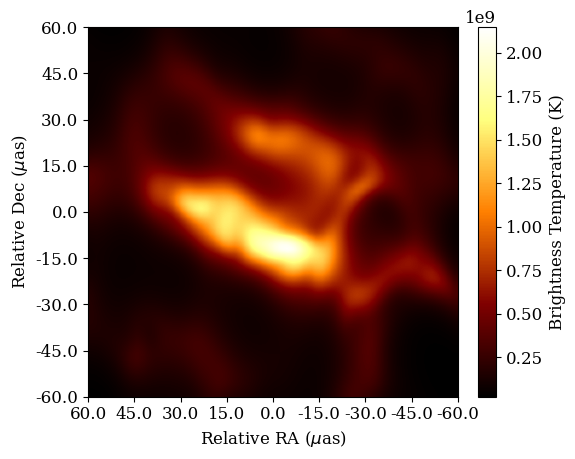

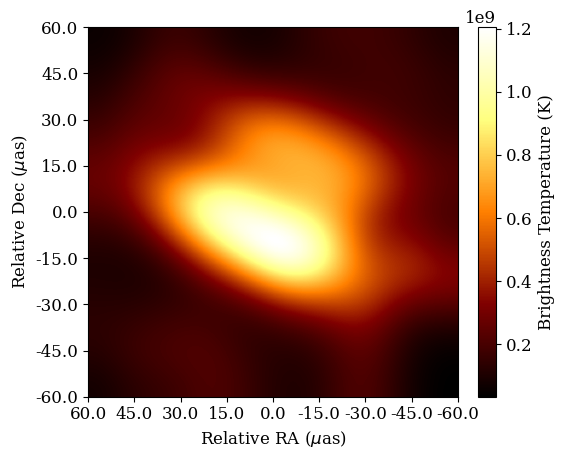

In [11]:
# display results
im_i_out.display(cbar_unit=['Tb'],has_title=False);
im_i_out.blur_circ(20*eh.RADPERUAS).display(cbar_unit=['Tb'],has_title=False);

In [12]:
cphase = imgr._data_tuples['cphase']
logcamp = imgr._data_tuples['logcamp']

In [13]:
print(cphase[0].shape, logcamp[0].shape)

(161,) (252,)


(cphase, logcamp) shapes will be displayed this way 

before->after

CI Avg:
- maxset False, SNR cut 2,  (159, 140) -> (159, 54)
- maxset True, SNR cut 2, (159, 140) -> (159, 140)

Vis avg:
- maxset False, (153, 228)-> (95, 74)
- maxset True, (153, 228) -> (153, 228)

For snr cut of 1 and 3 you get useless results but 2 works pretty well. It seems there is some balance to be struck between having enough visibilities, and having visibilities that are too noisy.

The following is called on clphase: (only if maxset != True. This is passed in when initialising the imager)

`clphasearr = obsh.reduce_tri_minimal(Obsdata, clphasearr)`





### I need to understand why the reduction happens before and after in both cases